In [83]:
# Required high precision
%run core.py

In [1]:
# Add job for training multiple classifiers and average

In [2]:
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
import sklearn.cross_validation as cv
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.mixture import GaussianMixture
from sklearn import cluster as cls
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense

In [3]:
df = pd.read_csv('./creditcard.csv')
print(len(df[df.Class == 0]))
print(len(df[df.Class == 1]))
c = df.columns
print(c)

284315
492
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [78]:
# RF
# Use random test train split for fitting classifier
from sklearn.ensemble import RandomForestClassifier
dftrain, dftest = cv.train_test_split(df)
xtrain, ytrain = dftrain.loc[:, c[1:-2]], dftrain.Class
xtest, ytest = dftest.loc[:, c[1:-2]], dftest.Class

In [77]:
# classifier = RandomForestClassifier(n_estimators=100, n_jobs=4)
# classifier.fit(xtrain, ytrain)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [74]:
# Load a pre-trained model
rf = pickle.load(open('./rf-16-09-2018_11:32:35', 'rb'))

In [79]:
tp, fp, tn, fn = evaluate(rf, xtest, ytest)
print(tp / (tp + fn))
print(tp / (tp + fp))
# save_scikit_model('rf', classifier)
ypred = rf.predict(xtest)

0.9586776859504132
0.9830508474576272


In [13]:
%%markdown
With no feature engineering, we get around 96percent precision with almost 99 percent true positive rate.
Simply stated, network catches around 96 percent of fradulent transactions and gives out a false alarm with only 1 percent

With no feature engineering, we get around 96percent precision with almost 99 percent true positive rate.
Simply stated, network catches around 96 percent of fradulent transactions and gives out a false alarm with only 1 percent

In [8]:
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2).fit_transform(xtest.loc[ytest == 1, c[1:-2]])

<IPython.core.display.Javascript object>


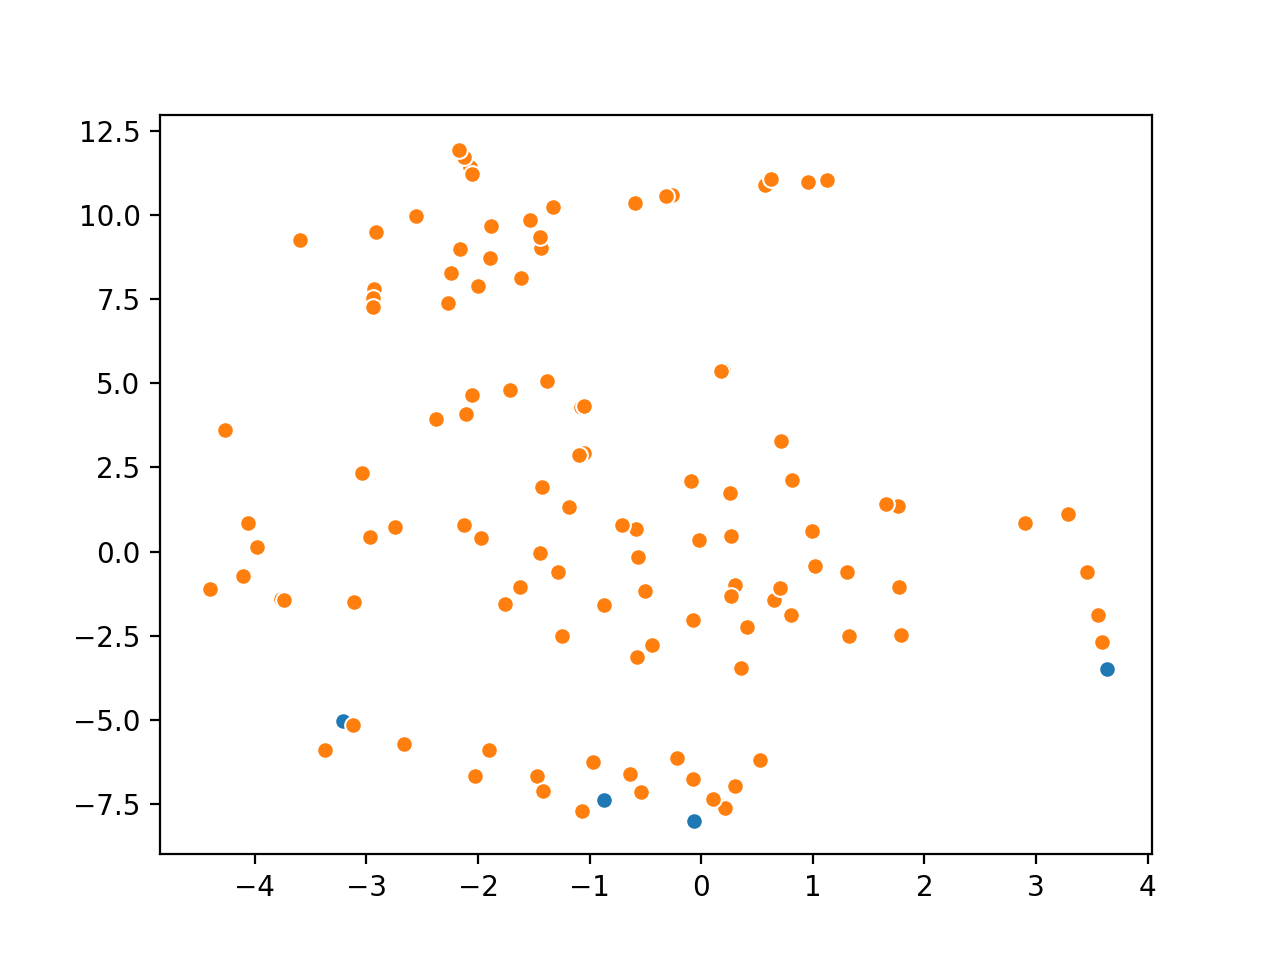

In [9]:
# Plot if predictions are missed in a given cluster
# Cluster is present for V1:V28 features (what does this mean ? )
ypred_p = ypred[ytest == 1]
y_p = ytest[ytest == 1]
x_tp = x_tsne[(ypred_p == 0) & (y_p == 1)]
x_fn = x_tsne[(ypred_p == 1) & (y_p == 1)]
plt.figure()
sns.scatterplot(x_tp[:, 0], x_tp[:, 1])
sns.scatterplot(x_fn[:, 0], x_fn[:, 1])
plt.show()

In [ ]:
"""
There is clearly two linearly separated clusters and the network misses more points in the lower cluster.
Maybe labelling issues ? 
"""

In [152]:
for i in range(1, 29):
    plt.figure()
    sns.distplot(df['V' + str(i)])
    plt.savefig('./dist-' + 'V' + str(i))

/Users/kushal/Software/venv3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [82]:
"""
Compute permutation importance to see which features are more important
This dataset is imbalanced so we use f1score rather than plain accuracy (code in core.py)
"""
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rf, random_state=1, scoring=f1score).fit(xtest, ytest)
eli5.show_weights(perm, feature_names = xtrain.columns.tolist())

Weight,Feature
0.0005 ± 0.0001,V14
0.0003 ± 0.0000,V17
0.0003 ± 0.0001,V4
0.0002 ± 0.0000,Amount
0.0002 ± 0.0000,V10
0.0001 ± 0.0000,V20
0.0001 ± 0.0000,V7
0.0001 ± 0.0000,V26
0.0001 ± 0.0000,V13
0.0001 ± 0.0000,V3


In [84]:
"""
Permutation importances based on f1scores are not so discriminative so we use precision and recall separately
Features that score high in recall are those that trigger the model but are not so important since they don't
help in precision
"""
perm = PermutationImportance(rf, random_state=1, scoring=precision).fit(xtest, ytest)
eli5.show_weights(perm, feature_names = xtrain.columns.tolist())

Weight,Feature
0.1438 ± 0.0169,V14
0.0876 ± 0.0081,V17
0.0793 ± 0.0247,V4
0.0628 ± 0.0081,Amount
0.0496 ± 0.0105,V10
0.0314 ± 0.0066,V26
0.0314 ± 0.0066,V20
0.0314 ± 0.0066,V7
0.0298 ± 0.0132,V13
0.0298 ± 0.0081,V3


In [85]:
"""
Permutation importances based on f1scores are not so discriminative 
"""
perm = PermutationImportance(rf, random_state=1, scoring=recall).fit(xtest, ytest)
eli5.show_weights(perm, feature_names = xtrain.columns.tolist())

Weight,Feature
0.0074 ± 0.0128,V26
0.0017 ± 0.0002,V17
0.0012 ± 0.0002,Amount
0.0009 ± 0.0002,V10
0.0006 ± 0.0001,V7
0.0006 ± 0.0001,V20
0.0005 ± 0.0002,V13
0.0005 ± 0.0001,V3
0.0004 ± 0.0001,V19
0.0004 ± 0.0001,V22
